# Synthesizing Images from the MNIST Fashion Dataset using Conditional Denoising Diffusion Probabilistic Models (DDPMs)

This notebook is a simple demonstration of generating images using conditional diffusion models.  We use the MNIST fashion dataset and a U-Net architecture with residual blocks and the diffusion and training process resembles [the approach described by Ho, et al., in this paper.](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf).  This notebook is similar to my notebook using the DDPMs for the MNIST hand-written digit dataset except that class-conditional inputs are also utilized.

Notable features:
- Residual blocks in UNet, second conv is 1x1
- SiLU activations
- Group normalization, size 4
- Average pooling downsampling
- Pixel-shuffle upsampling
- Concatenation cross-connections
- No separate bridge
- No self-attention layers
- MLP-style adaptor net
- Class-conditional inputs, combined using sum in 2nd conv layer
- No position embeddings, betas and alpha-bars fed directly
- One-cycle learning rate scheduler

---

Elliott Forney - 2023

In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)

import IPython

In [2]:
import collections
import gzip
import itertools
import random
import struct

import tqdm.notebook as tqdm
import munch

import numpy as np
import matplotlib.pyplot as plt

import skimage as ski
import skimage.io as _

import torch as th
import torchinfo

## MNIST Fashion Dataset

This dataset is very similar to the MNIST hand-written dataset in terms of the format and the size of the dataset.  Instead of hand-written digits, however, it consists of images of fashion items.

In [3]:
class MNISTFashion(th.utils.data.Dataset):
    '''The MNIST fashion dataset.
    '''
    def __init__(self, train=True):
        '''Initialize a new MNIST dataset.  If `train` is ``True``, then
        load the training partition.  Otherwise, load the validation partition.
        '''
        super().__init__()
        self.imgs, self.labels = self._load_imgs(train)
        
    @staticmethod
    def _load_imgs(train):
        '''Load all of the training images.  This dataset is relatively small,
        so we just keep everything in memory on the CPU side.

        Thanks:
            https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format
        '''
        prefix = 'train' if train else 't10k'

        with gzip.open(f'../../data/torchvision/FashionMNIST/raw/{prefix}-images-idx3-ubyte.gz', mode='rb') as fh:
            _magic, size = struct.unpack('>II', fh.read(8))
            nrows, ncols = struct.unpack('>II', fh.read(8))
            data = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
            imgs = data.reshape((size, 1, nrows, ncols)) / 255.
                
        with gzip.open(f'../../data/torchvision/FashionMNIST/raw/{prefix}-labels-idx1-ubyte.gz', mode='rb') as fh:
            _magic, _size = struct.unpack('>II', fh.read(8))
            labels = np.frombuffer(fh.read(), dtype=np.dtype(np.uint8).newbyteorder('>')).copy()

        return th.as_tensor(imgs, dtype=th.float32), th.as_tensor(labels, dtype=th.int64)

    def __getitem__(self, idx):
        '''Return a single image and the corresponding label
        specified by the given index.
        '''
        return self.imgs[idx], self.labels[idx]
    
    def __len__(self):
        '''Return the number of images in the dataset.
        '''
        return self.imgs.shape[0]
    
    def plot(self, idx):
        '''Plot the image specified by the given index.
        '''
        fig, ax = plt.subplots()
        ax.imshow(self.imgs[idx], cmap=plt.cm.gray_r)
        ax.axis('off')
        
    def plot_montage(self, n=36, seed=42):
        '''Plot a montage of `n` randomly selected images.
        '''
        rng = random.Random(seed)
        idxs = rng.sample(range(len(self)), n)

        imgs = th.stack([self[idx][0] for idx in idxs], dim=0)
        montage = ski.util.montage(
            np.moveaxis(imgs.numpy(), 1, -1), channel_axis=-1)
        
        fig, ax = plt.subplots()
        ax.imshow(montage, cmap=plt.cm.gray_r)
        ax.axis('off')

In [4]:
train_data = MNISTFashion(train=True)
val_data = MNISTFashion(train=False)

len(train_data), len(val_data)

(60000, 10000)

In [5]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [6]:
train_data[0][1]

tensor(9)

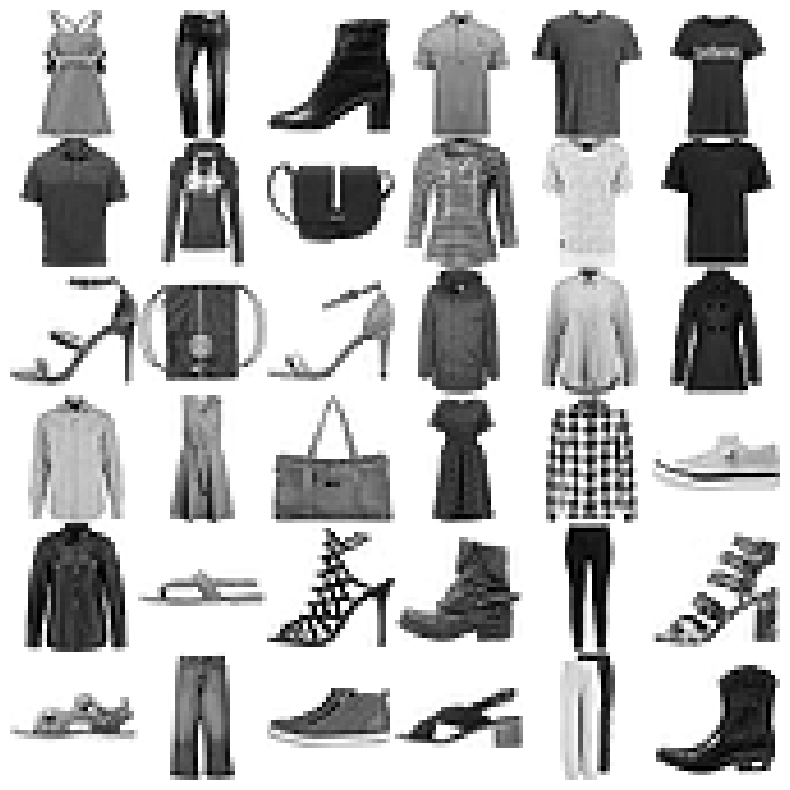

In [7]:
train_data.plot_montage()

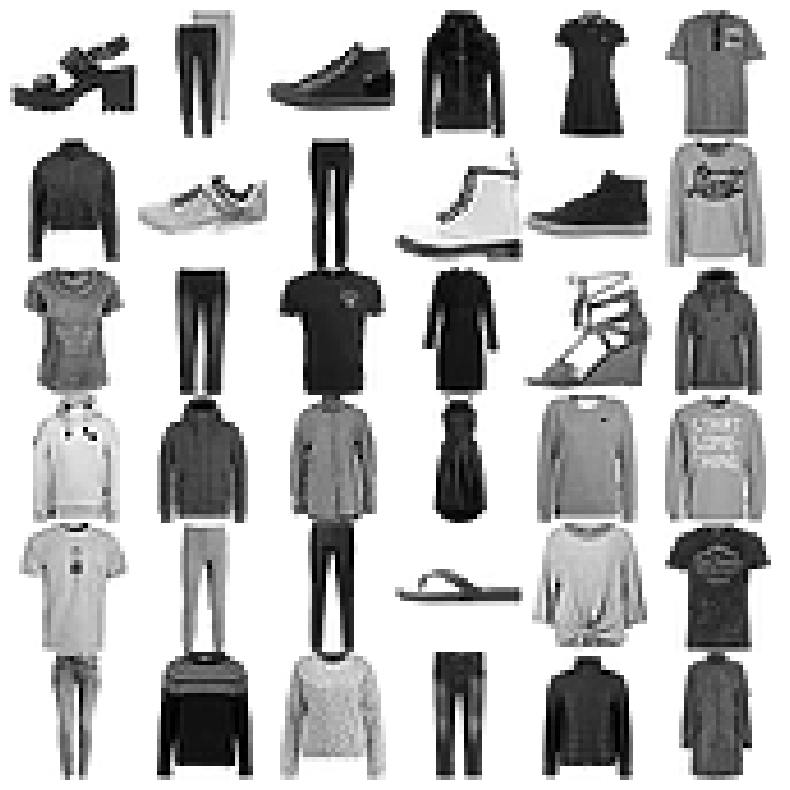

In [8]:
val_data.plot_montage()

## Custom layers

In [9]:
class _Linear(th.nn.Linear):
    '''Dense linear layer with linear Kaiming weight initialization.
    '''
    def reset_parameters(self):
        th.nn.init.kaiming_normal_(self.weight)
        if getattr(self, 'bias', None) is not None:
            th.nn.init.zeros_(self.bias)

In [10]:
class _Conv2d(th.nn.Conv2d):
    '''Convolutional layer with Kaiming weight initialization
    and "same" padding built in.
    '''
    def __init__(self, in_chans, out_chans, kernel_size, **kwargs):
        super().__init__(
            in_chans, out_chans,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            **kwargs,
        )
        
    def reset_parameters(self):
        th.nn.init.kaiming_normal_(self.weight)
        if getattr(self, 'bias', None) is not None:
            th.nn.init.zeros_(self.bias)

In [11]:
class _Downsample(th.nn.Module):
    '''Average downsampling.
    '''
    def forward(self, x):
        return th.nn.functional.avg_pool2d(
            x, kernel_size=2, ceil_mode=True)

In [12]:
class _Upsample(th.nn.Module):
    '''Pixel-shuffle upsampling.
    '''
    def forward(self, x):
        return th.nn.functional.pixel_shuffle(x, upscale_factor=2)

## Residual block & adaptor net

In [13]:
class _ResidBlock(th.nn.Module):
    '''A residual-style convolutional block with two convolutions
    surrounding a single SiLU activation.  Group-norm is applied
    after each convolution and an "adaptor" input is incorporated
    into the first convolution via linear combination.  This adaptor
    input is used to control behavior based on the diffusion step
    and, possibly, any conditional inputs.
    '''
    def __init__(self, in_chans, out_chans, adapt_dim, kernel_size=3):
        super().__init__()
        
        self.remix = th.nn.Identity() if in_chans == out_chans \
            else _Conv2d(in_chans, out_chans, kernel_size=1)

        self.conv1 = _Conv2d(in_chans, 2*out_chans, kernel_size=kernel_size, bias=False)
        self.norm1 = th.nn.GroupNorm(4, 2*out_chans)
        self.act = th.nn.SiLU()
        self.conv2 = _Conv2d(2*out_chans, out_chans, kernel_size=1, bias=False)
        self.adapt = _Linear(adapt_dim, out_chans, bias=False)
        self.norm2 = th.nn.GroupNorm(4, out_chans)

        self.register_buffer('scale', th.as_tensor(2.).rsqrt())

    def forward(self, x, w):
        batch_size, num_chans, height, width = x.shape

        r = self.act(self.norm1(self.conv1(x)))
        r = self.norm2(self.conv2(r) + self.adapt(w)[:, :, None, None])

        return self.scale * (self.remix(x) + r)

In [14]:
class _AdaptNet(th.nn.Sequential):
    '''A dense MLP-style network with SiLU activations
    that is used to process information about the current
    diffusion step and any conditional inputs.
    '''
    def __init__(self, in_chans, out_chans, num_layers):
        super().__init__()

        layer_in, layer_out = None, in_chans
        for _ in range(num_layers):
            layer_in, layer_out = layer_out, out_chans
            
            self.append(
                th.nn.Sequential(
                    _Linear(layer_in, layer_out),
                    th.nn.SiLU(),
                )
            )

## Residual UNet

In [15]:
class _EncoderLevel(th.nn.Module):
    '''An encoder level, aka stage, for our UNet.  The ouputs
    pre and post downsampling are returned for use in the
    following stage and cross connection, respectively.
    Inputs are taken from the previous level as well as
    the adaptor net.
    '''
    def __init__(self, in_chans, out_chans, num_layers, adapt_dim,
                 kernel_size, downsample=True):
        super().__init__()

        self.blocks = th.nn.ModuleList()
        layer_in, layer_out = None, in_chans
        for _ in range(num_layers):
            layer_in, layer_out = layer_out, out_chans
            
            self.blocks.append(
                _ResidBlock(
                    layer_in, layer_out,
                    adapt_dim=adapt_dim,
                    kernel_size=kernel_size,
                )
            )

        self.downsample = _Downsample() if downsample \
            else th.nn.Identity()

    def forward(self, x, w):
        for block in self.blocks:
            x = block(x, w)

        return self.downsample(x), x

In [16]:
class _Encoder(th.nn.Module):
    '''A full UNet encoder.
    '''
    def __init__(self, in_chans, layer_specs, adapt_dim):
        super().__init__()
        
        self.levels = th.nn.ModuleList()
        encoder_levels = len(layer_specs)
        layer_in, layer_out = None, in_chans
        for layer_idx, (num_layers, num_filters, kernel_size) in enumerate(layer_specs):
            layer_in, layer_out = layer_out, num_filters
            downsample = layer_idx < encoder_levels - 1
            
            self.levels.append(
                _EncoderLevel(
                    layer_in, layer_out,
                    num_layers=num_layers,
                    adapt_dim=adapt_dim,
                    kernel_size=kernel_size,
                    downsample=downsample,
                )
            )
            
    def forward(self, x, w):
        cross_outs = []
        
        for enc in self.levels:
            x, cross_out = enc(x, w)
            cross_outs.append(cross_out)
        
        return x, cross_outs[:-1]

In [17]:
class _DecoderLevel(th.nn.Module):
    '''An decoder level, aka stage, for our UNet.  Inputs are
    fed from both the previous level as well as the cross
    connections and adaptor net.
    '''
    def __init__(self, in_chans, out_chans, num_layers, adapt_dim, kernel_size):
        super().__init__()
        
        self.upsample = _Upsample()
        
        self.blocks = th.nn.Sequential()
        layer_in, layer_out = None, in_chans // 4 + out_chans
        for _ in range(num_layers):
            layer_in, layer_out = layer_out, out_chans
            
            self.blocks.append(
                _ResidBlock(
                    layer_in, layer_out,
                    adapt_dim=adapt_dim,
                    kernel_size=kernel_size,
                )
            )
            
    def forward(self, x, w, cross):
        x = self.upsample(x)
        x = th.cat((x, cross), dim=1)
        
        for block in self.blocks:
            x = block(x, w)
        
        return x

In [18]:
class _Decoder(th.nn.Module):
    '''A full UNet decoder.
    '''
    def __init__(self, in_chans, layer_specs, adapt_dim):
        super().__init__()

        self.levels = th.nn.ModuleList()
        layer_in, layer_out = None, in_chans
        for num_layers, num_filters, kernel_size in layer_specs:
            layer_in, layer_out = layer_out, num_filters
            
            self.levels.append(
                _DecoderLevel(
                    layer_in, layer_out,
                    num_layers=num_layers,
                    adapt_dim=adapt_dim,
                    kernel_size=kernel_size,
                )
            )
            
    def forward(self, x, w, cross_outs):
        for dec in self.levels:
            x = dec(x, w, cross_outs.pop(-1))
            
        assert not cross_outs
        
        return x

In [19]:
_default_layer_specs = (
    (1, 16, 5), # 28
    (2, 32, 3), # 14
    (4, 64, 3), # 7
)

_LayerSpec = collections.namedtuple(
    '_LayerSpec', ('num_layers', 'num_filters', 'kernel_size'),
    defaults=(3,))

class UNet(th.nn.Module):
    '''A 2D residual UNet with conditional inputs.
    '''
    def __init__(self, in_chans=1, out_chans=1, layer_specs=_default_layer_specs,
                 num_cond=2, adapt_dim=32, adapt_layers=4):
        super().__init__()
        
        self.layer_specs = tuple(itertools.starmap(_LayerSpec, layer_specs))
        self.num_cond = num_cond
        self.adapt_dim = adapt_dim
        
        self.adapt_net = _AdaptNet(
            self.num_cond, self.adapt_dim,
            num_layers=adapt_layers,
        )

        self.encoder = _Encoder(
            in_chans,
            layer_specs=self.layer_specs,
            adapt_dim=self.adapt_dim,
        )
        
        self.decoder = _Decoder(
            self.layer_specs[-1].num_filters,
            layer_specs=reversed(self.layer_specs[:-1]),
            adapt_dim=self.adapt_dim,
        )

        self.readout = _Conv2d(
            self.layer_specs[0].num_filters, out_chans, kernel_size=1)
        
    def forward(self, x, w):
        batch_size, num_chans, height, width = x.shape
        assert w.shape == (batch_size, self.num_cond)
        
        w = self.adapt_net(w)
        assert w.shape == (batch_size, self.adapt_dim)
        
        x, cross_outs = self.encoder(x, w)
        
        x = self.decoder(x, w, cross_outs)
        
        return self.readout(x)

## Initialize the UNet and ensure reasonable distribution of ouputs

In [20]:
net = UNet()
#net

In [21]:
sum(p.numel() for p in net.parameters())

417505

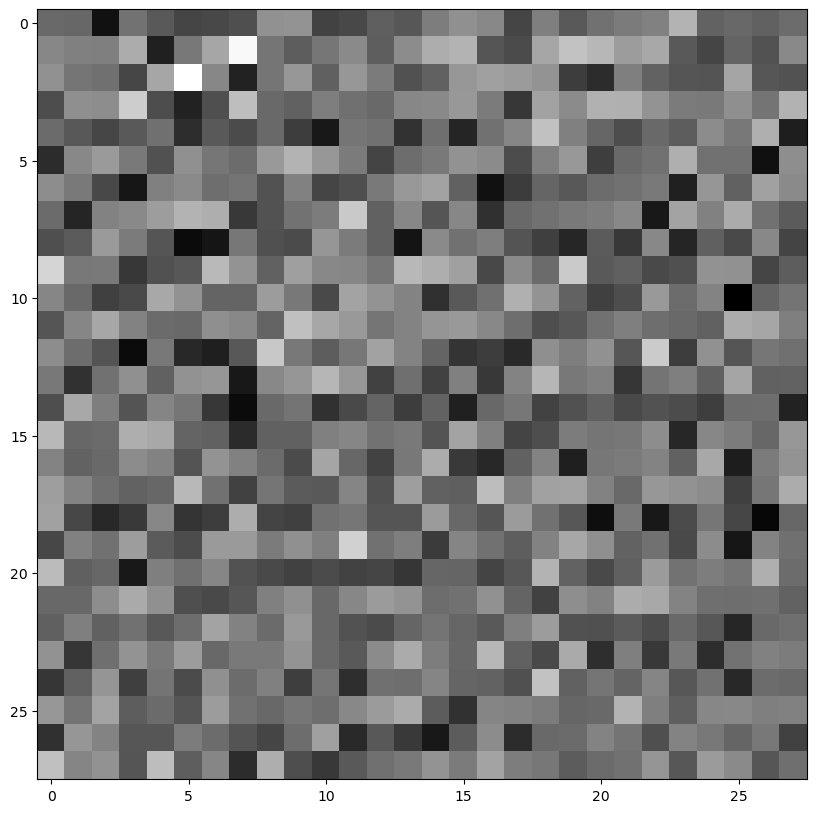

In [22]:
with th.no_grad():
    x = net(th.randn(32, 1, 28, 28), th.randn(32, 2))

x -= x.min()
x /= x.max()
    
plt.imshow(x[0].numpy().squeeze(0), cmap=plt.cm.gray_r);

## Denoising Diffusion Probabilistic Model (DDPM)

In [23]:
class DiffusionModel(th.nn.Module):
    '''A Denoising Diffusion Probabilistic Model (DDPM) using
    a residual-style UNet.
    '''
    def __init__(self, num_chans=1, num_labels=10, diffusion_steps=1_000, beta_0=1e-4, beta_T=0.012,
                 means=(0.1307,), stdevs=(0.3081,), **kwargs):
        super().__init__()

        self.num_chans = num_chans
        self.num_labels = num_labels
        self.diffusion_steps = diffusion_steps

        # Precomputed parameters.  Maybe it's not so fast to gather since
        # memory accesses are slow but this is convenient because we have
        # to compute some things cumulatively.
        self.register_buffer(
            'betas', th.linspace(beta_0, beta_T, self.diffusion_steps), persistent=False)
        self.register_buffer(
            'alphas', 1. - self.betas, persistent=False)
        self.register_buffer(
            'rsqrt_alphas', self.alphas.rsqrt(), persistent=False)
        self.register_buffer(
            'alpha_bars', th.cumprod(self.alphas, dim=0), persistent=False)
        self.register_buffer(
            'sqrt_alpha_bars', self.alpha_bars.sqrt(), persistent=False)
        self.register_buffer(
            'rsqrt_alpha_bars', self.alpha_bars.rsqrt(), persistent=False)
        self.register_buffer(
            'sqrt_1m_alpha_bars', (1. - self.alpha_bars).sqrt(), persistent=False)
        self.register_buffer(
            'rsqrt_1m_alpha_bars', (1. - self.alpha_bars).rsqrt(), persistent=False)

        ## Posterier noise / sigmas
        
        # Two forms of sigmas here represent bounds in the paper.
        # It doesn't seem to matter much which is used but the second
        # converges to zero.

        #self.register_buffer(
        #    'sigmas', self.betas.sqrt(), persistent=False)
        
        alpha_bars_prev = th.nn.functional.pad(self.alpha_bars[:-1], (1, 0), value=1.)
        self.register_buffer(
            'sigmas', th.sqrt(self.betas * (1. - alpha_bars_prev) / (1. - self.alpha_bars)),
            persistent=False)
        
        ## Inputs to adapt net

        steps = th.linspace(beta_0, beta_T, self.diffusion_steps)
        steps -= steps.mean()
        steps /= steps.std()

        std_alpha_bars = self.alpha_bars.clone()
        std_alpha_bars -= std_alpha_bars.mean()
        std_alpha_bars /= std_alpha_bars.std()

        self.register_buffer(
            'omegas', th.stack((steps, std_alpha_bars), dim=1), persistent=False)

        ## Means & stdevs

        self.register_buffer(
            'means', th.as_tensor(means, dtype=th.float32).view(1, -1, 1, 1))
        self.register_buffer(
            'stdevs', th.as_tensor(stdevs, dtype=th.float32).view(1, -1, 1, 1))
        self.register_buffer('rstdevs', 1. / self.stdevs)

        ## Initialize UNet

        self.net = UNet(
            in_chans=num_chans,
            out_chans=num_chans,
            num_cond=self.omegas.shape[1] + self.num_labels,
            **kwargs,
        )

    def standardize(self, x):
        '''Standardize the input images to have zero mean
        and unit variance.
        '''
        return (x - self.means) * self.rstdevs

    def unstandardize(self, x):
        '''Reverse standardization back to the scaling
        of the original images.
        '''
        return (x * self.stdevs) + self.means

    @staticmethod
    @th.no_grad()
    def _gather(v, t):
        '''Gather parameters for a given diffusion step.
        '''
        return v[t].view(-1, 1, 1, 1)

    @th.no_grad()
    def add_noise(self, x, t):
        '''Introduce noise, i.e., corrupt the image for
        a specified diffusion step `t`.
        '''
        x = self.standardize(x)

        sqrt_alpha_bars = self._gather(self.sqrt_alpha_bars, t)
        sqrt_1m_alpha_bars = self._gather(self.sqrt_1m_alpha_bars, t)

        noise = th.randn_like(x)
        x = sqrt_alpha_bars * x + sqrt_1m_alpha_bars * noise

        return x, noise

    @th.no_grad()
    def remove_noise(self, noisy_x, t, noise_preds=None):
        '''Remove the noise at a given diffusion step.
        This is useful for debugging and visualization.
        '''
        if noise_preds is None:
            noise_preds = self(noisy_x, t)

        sqrt_1m_alpha_bars = self._gather(self.sqrt_1m_alpha_bars, t)
        rsqrt_alpha_bars = self._gather(self.rsqrt_alpha_bars, t)

        return self.unstandardize(
            (noisy_x - sqrt_1m_alpha_bars * noise_preds) * rsqrt_alpha_bars)

    @th.no_grad()
    def predict(self, x, labels, diffusion_steps=None):
        '''Reverse diffusion process.  This generates
        images from noise or a partially corrupted image.
        '''
        batch_size, _num_chans, _height, _width = x.shape
        diffusion_steps = diffusion_steps or self.diffusion_steps

        for step in reversed(range(diffusion_steps)):
            beta = self.betas[step]
            rsqrt_1m_alpha_bar = self.rsqrt_1m_alpha_bars[step]
            rsqrt_alpha = self.rsqrt_alphas[step]
            sigma = self.sigmas[step]

            t = th.full((batch_size,), step, dtype=th.int64, device=x.device)
            noise_preds = self(x, t, labels)

            x -= beta * rsqrt_1m_alpha_bar * noise_preds

            noise = th.randn_like(x) if step > 0 else 0.
            x = rsqrt_alpha * x + sigma * noise

        return self.unstandardize(x)

    def forward(self, x, t, labels):
        '''Forward pass is deligated to the UNet.
        '''
        batch_size, in_chans, height, width = x.shape

        omegas = self.omegas[t]
        assert omegas.shape == (batch_size, 2)
        
        indicators = -th.ones(batch_size, self.num_labels, device=labels.device)
        indicators.scatter_(1, labels[:, None], 1.)
        assert indicators.shape == (batch_size, self.num_labels)
        
        w = th.cat((omegas, indicators), dim=1)

        return self.net(x, w=w)

## Initialize the DDPM

In [24]:
model = DiffusionModel(num_chans=1)

In [25]:
torchinfo.summary(model, depth=4)

Layer (type:depth-idx)                                  Param #
DiffusionModel                                          --
├─UNet: 1-1                                             --
│    └─_AdaptNet: 2-1                                   --
│    │    └─Sequential: 3-1                             --
│    │    │    └─_Linear: 4-1                           416
│    │    │    └─SiLU: 4-2                              --
│    │    └─Sequential: 3-2                             --
│    │    │    └─_Linear: 4-3                           1,056
│    │    │    └─SiLU: 4-4                              --
│    │    └─Sequential: 3-3                             --
│    │    │    └─_Linear: 4-5                           1,056
│    │    │    └─SiLU: 4-6                              --
│    │    └─Sequential: 3-4                             --
│    │    │    └─_Linear: 4-7                           1,056
│    │    │    └─SiLU: 4-8                              --
│    └─_Encoder: 2-2                     

## Visualize the noise schedule

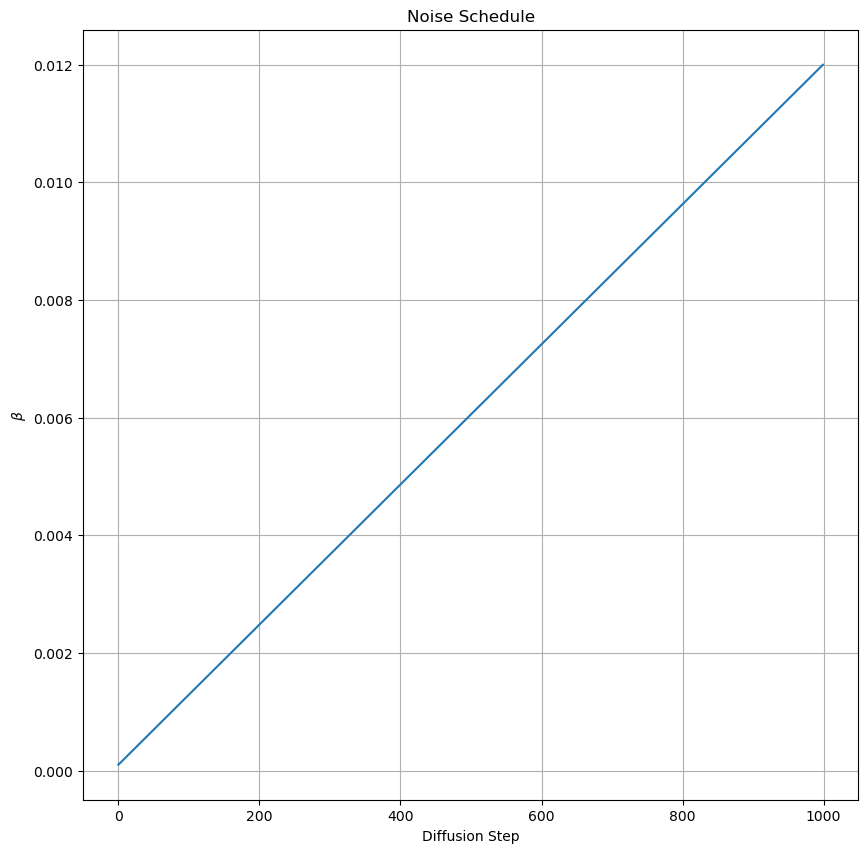

In [26]:
plt.plot(model.betas);
plt.title('Noise Schedule');
plt.xlabel('Diffusion Step');
plt.ylabel(r'$\beta$');
plt.grid();

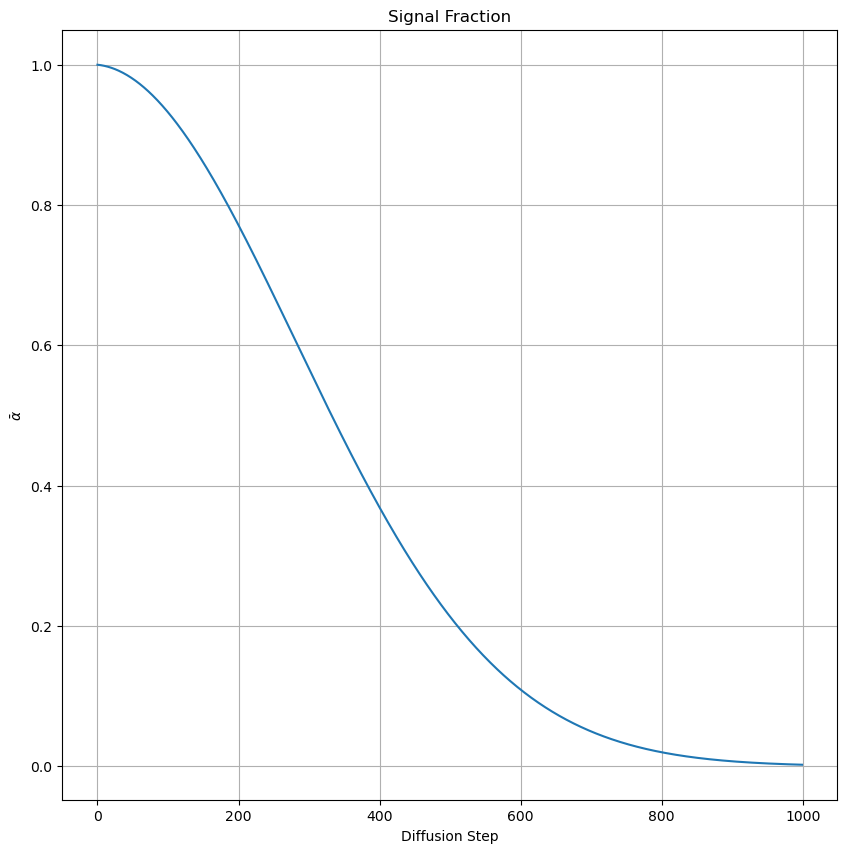

In [27]:
plt.plot(model.alpha_bars);
plt.title('Signal Fraction')
plt.xlabel('Diffusion Step');
plt.ylabel(r'$\bar{\alpha}$')
plt.grid();

In [28]:
imgs = train_data[42][0].expand(100, 1, 28, 28)
imgs.shape

torch.Size([100, 1, 28, 28])

In [29]:
t = th.linspace(0, model.diffusion_steps-1, 100, dtype=th.int64)
t

tensor([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 111, 121, 131,
        141, 151, 161, 171, 181, 191, 201, 211, 222, 232, 242, 252, 262, 272,
        282, 292, 302, 312, 322, 333, 343, 353, 363, 373, 383, 393, 403, 413,
        423, 433, 444, 454, 464, 474, 484, 494, 504, 514, 524, 534, 544, 555,
        565, 575, 585, 595, 605, 615, 625, 635, 645, 655, 666, 676, 686, 696,
        706, 716, 726, 736, 746, 756, 766, 777, 787, 797, 807, 817, 827, 837,
        847, 857, 867, 877, 888, 898, 908, 918, 928, 938, 948, 958, 968, 978,
        988, 999])

In [30]:
noisy_imgs, noise = model.add_noise(imgs, t)

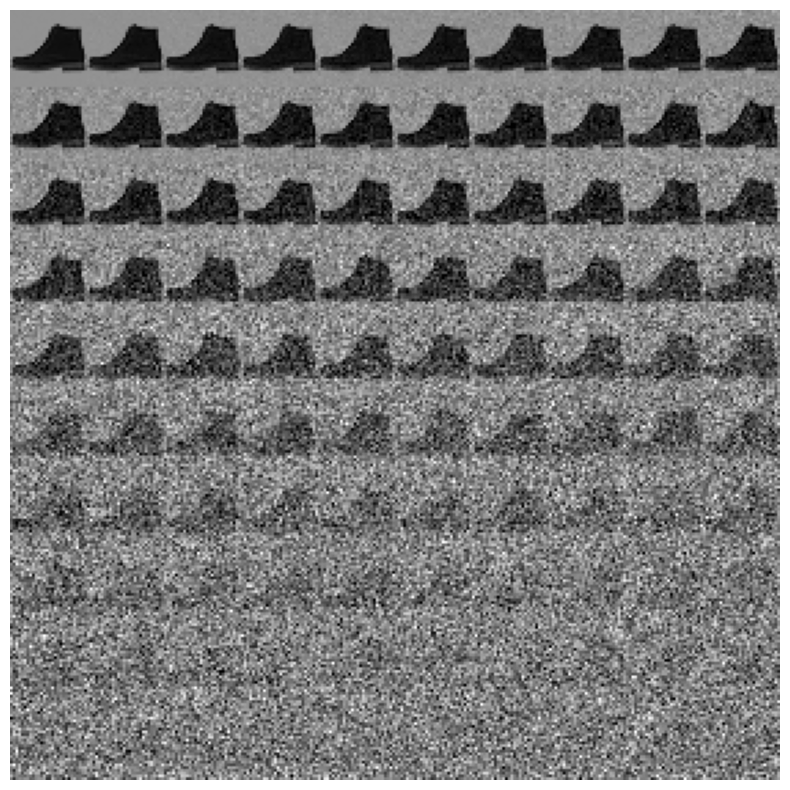

In [31]:
montage = ski.util.montage(noisy_imgs.numpy(), channel_axis=1)
montage = montage.clip(-3., 3.)
montage -= montage.min()
montage /= montage.max()
plt.imshow(montage, cmap=plt.cm.gray_r);
plt.axis('off');

In [32]:
denoised_imgs = model.remove_noise(noisy_imgs, t, noise_preds=noise)

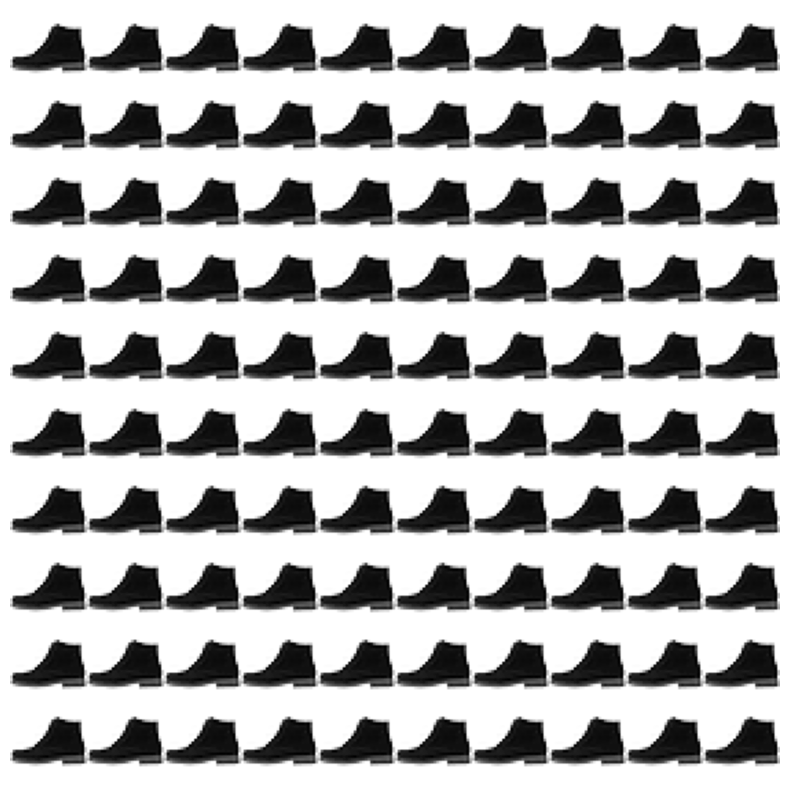

In [33]:
montage = ski.util.montage(denoised_imgs.clamp(0., 1.).numpy(), channel_axis=1)
plt.imshow(montage, cmap=plt.cm.gray_r);
plt.axis('off');

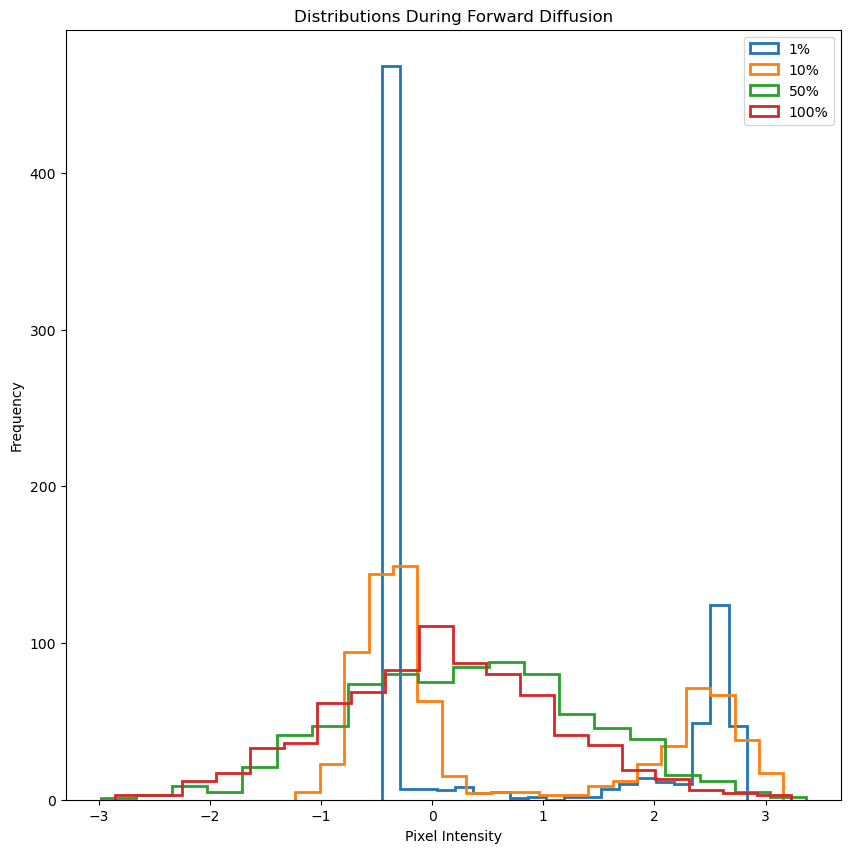

In [34]:
def plot_dist(noisy_imgs, idx):
    plt.hist(
        np.moveaxis(noisy_imgs[idx].numpy(), 0, -1).reshape(-1, 1),
        bins=20,
        histtype='step',
        density=False,
        linewidth=2,
        label=f'{idx+1}%',
    );

plot_dist(noisy_imgs, 0)
plot_dist(noisy_imgs, 9)
plot_dist(noisy_imgs, 49)
plot_dist(noisy_imgs, 99)

plt.legend();
plt.title('Distributions During Forward Diffusion')
plt.xlabel('Pixel Intensity');
plt.ylabel('Frequency');

## Training

In [35]:
def train(model, train_data, val_data, epochs=250, batch_size=128, grad_accum=1, lr=0.00085,
          weight_decay=0.001, num_workers=10, device=0):
    '''Train a diffusion model using the AdamW optimizer and a one-cycle
    learning rate scheduler.
    
    model:
        The diffusion model.
    train_data:
        Training dataset.
    val_data:
        Validation dataset.
    epochs (int):
        Numer of epochs to train for.
    batch_size (int):
        Size of training batches.
    grad_accum (int):
        Number of batches over which gradients will be accumulated
        before peforming a backword pass.  This increases the
        effective batch size.
    lr (float):
        The learning rate.
    weight_decay (float):
        The weight decay value used for AdamW.
    num_workers (int):
        Number of worker processes to use for
        the dataloaders.
    device:
        The hardware accelerator device ID.
    '''
    # Initialize the dataloaders
    train_dataloader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True)
    
    val_dataloader = th.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    # Move the model to the accelerator device
    model.to(device)
    
    # Initialize the optimizer
    optimizer = th.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Initialize the learning rate scheduler
    train_steps_per_epoch = len(train_dataloader) // grad_accum
    lr_sched = th.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=epochs,
        steps_per_epoch=train_steps_per_epoch,
        cycle_momentum=False,
        div_factor=10.,
    )

    # Metrics to track
    train_losses = []
    val_losses = []
    lrs = []

    # Display handle for IPython visualizations
    dh = None
    
    for epoch in (epoch_bar := tqdm.trange(epochs, desc='epoch', leave=True)):
        optimizer.zero_grad()

        # Training loop
        model.train()
        train_losses_step = []
        train_bar = tqdm.tqdm(train_dataloader, desc='train', leave=False)
        for step, (imgs, labels) in enumerate(train_bar):            
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Draw random diffusion steps
            t = th.randint(0, model.diffusion_steps, size=(batch_size,), device=device)
            noisy_imgs, noise = model.add_noise(imgs, t)
    
            # Forward pass
            noise_preds = model(noisy_imgs, t, labels)

            # Compute MSE loss
            loss = th.nn.functional.mse_loss(noise_preds, noise) / grad_accum
            train_losses_step.append(loss.item())
            
            # Backward pass
            loss.backward()
            if (step + 1) % grad_accum == 0:
                optimizer.step()
                optimizer.zero_grad()

                lrs.append(optimizer.param_groups[0]['lr'])
                lr_sched.step()
                
        train_losses.append(sum(train_losses_step) / len(train_losses_step))
        
        # Validation loop
        model.eval()
        val_losses_step = []
        val_bar = tqdm.tqdm(val_dataloader, desc='val', leave=False)
        for step, (imgs, labels) in enumerate(val_bar):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Use equally spaced diffusion steps for consistency
            # in validation metrics.
            t = th.linspace(
                0, model.diffusion_steps-1, imgs.shape[0], dtype=th.int64, device=device)
            noisy_imgs, noise = model.add_noise(imgs, t)
            
            # Forward pass and loss computation
            with th.no_grad():
                noise_preds = model(noisy_imgs, t, labels)
                loss = th.nn.functional.mse_loss(noise_preds, noise)
                
            val_losses_step.append(loss.item())
            
        val_losses.append(sum(val_losses_step) / len(val_losses_step))
        
        # Put some metrics on the progress bar
        epoch_bar.set_postfix({
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'lr': optimizer.param_groups[0]['lr']
        })

        # Plot a visualization in the notebook every 10 epochs
        if epoch % 10 == 0:            
            rand_imgs = th.randn(36, *imgs.shape[1:], device=device)
            rand_labels = th.randint(0, model.num_labels, size=(36,), device=device)

            generated_imgs = model.predict(rand_imgs, rand_labels)
            
            #generated_imgs -= generated_imgs.min()
            #generated_imgs /= generated_imgs.max()
            generated_imgs.clip(0., 1.)
            
            montage = ski.util.montage(generated_imgs.cpu().numpy(), channel_axis=1)

            fig, ax = plt.subplots()
            ax.imshow(montage, plt.cm.gray_r)
            ax.axis('off')
            fig.tight_layout()

            if dh is None:
                dh = IPython.display.display(fig, display_id=True)
            else:
                dh.update(fig)
            plt.close(fig)
            
            # Save a checkpoint.
            #th.save(model.state_dict(), f'mnist_fashion_conditional_ddpm_{epoch=}.pt')

    # Put model back in eval mode on CPU.
    model.eval()
    model.cpu()

    # Empty CUDA caches to free memory for later.
    th.cuda.empty_cache()
    
    # Return metrics in a munch.
    return munch.Munch(
        train_losses=train_losses,
        val_losses=val_losses,
        lrs=lrs,
    )

epoch:   0%|          | 0/250 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

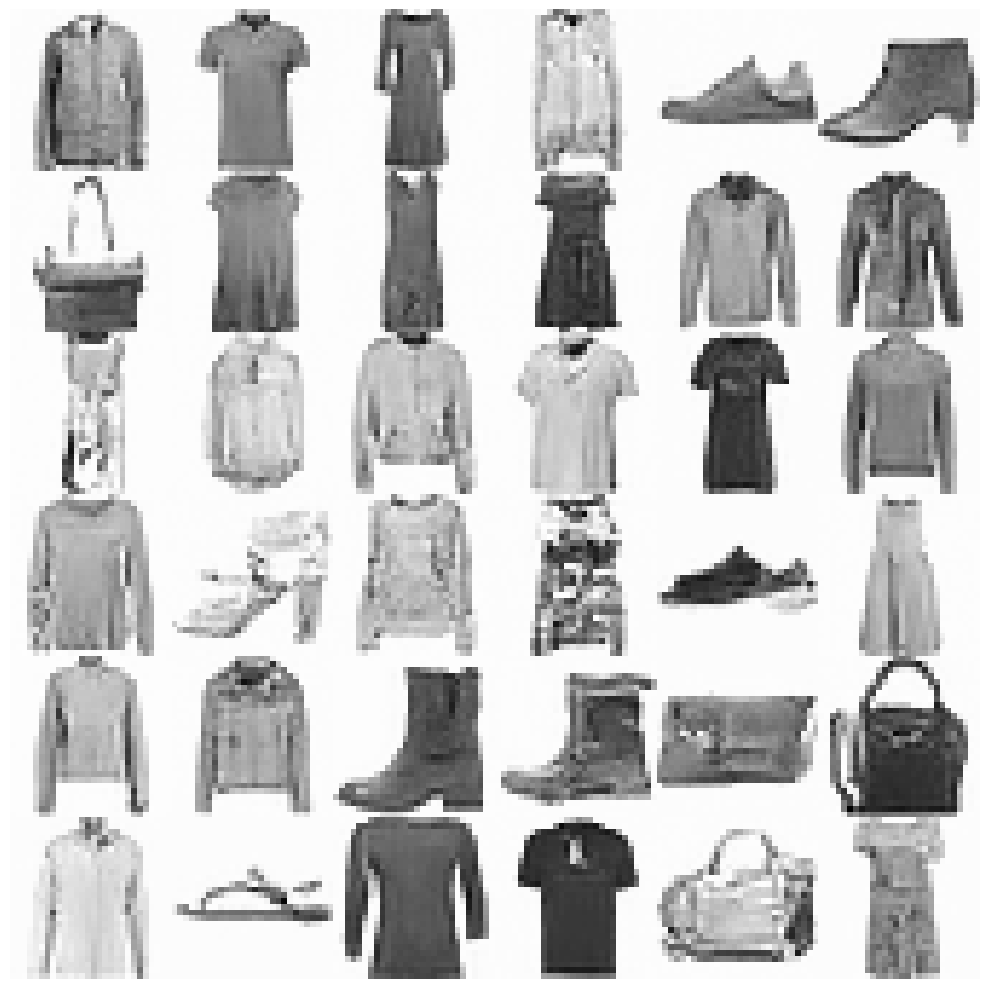

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

train:   0%|          | 0/468 [00:00<?, ?it/s]

val:   0%|          | 0/79 [00:00<?, ?it/s]

In [36]:
result = train(model, train_data, val_data, device=0)

## Metrics

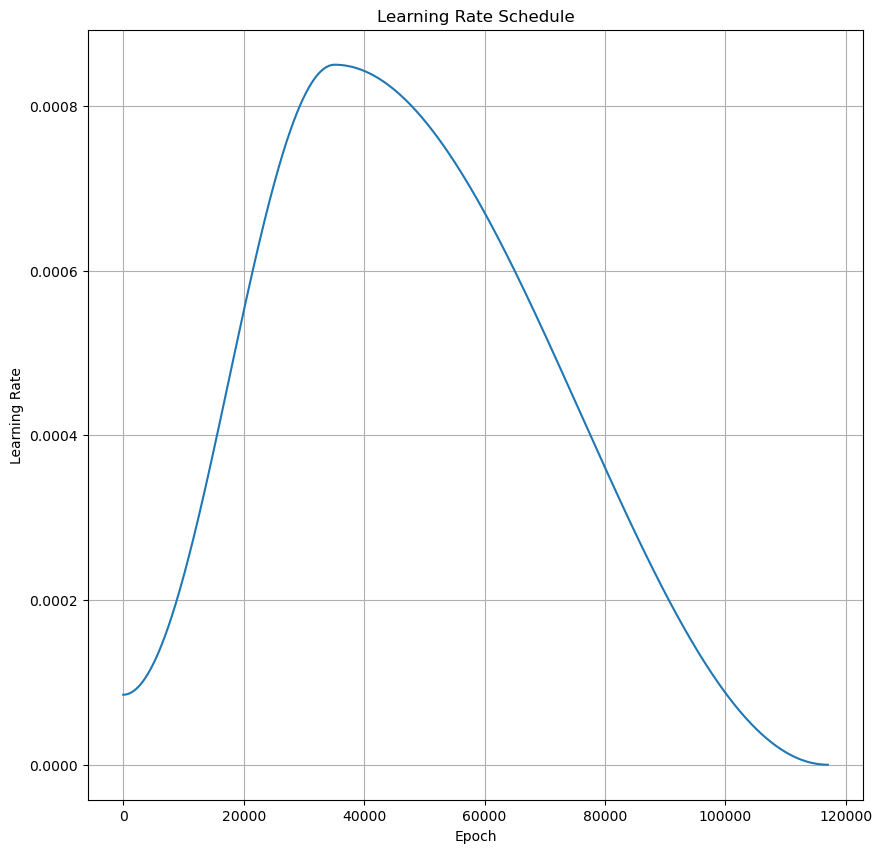

In [37]:
plt.plot(result.lrs);
plt.grid();
plt.title('Learning Rate Schedule');
plt.xlabel('Epoch');
plt.ylabel('Learning Rate');

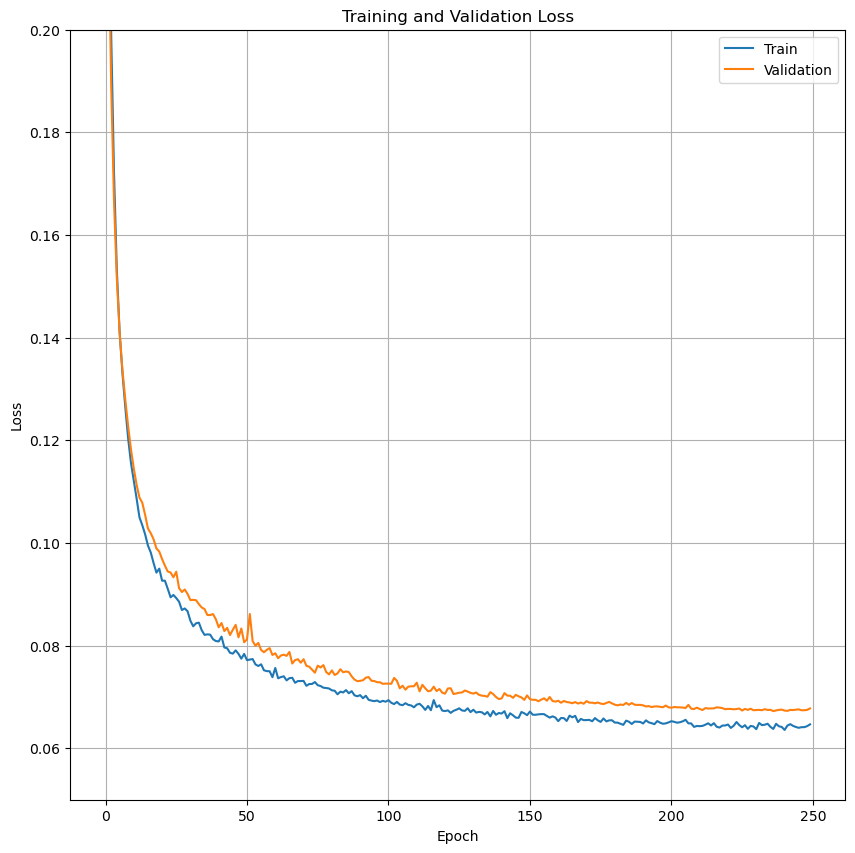

In [38]:
plt.plot(result.train_losses, label='Train');
plt.plot(result.val_losses, label='Validation');
plt.legend();
plt.grid();
plt.title('Training and Validation Loss')
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.ylim(0.05, 0.2);

## Example synthetic images

In [39]:
model.to(0);

In [40]:
label_names = [
    'TShirt_or_top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle_boot',
]

@th.no_grad()
def plot_montage(model, n=36, label=None):
    device = model.net.readout.weight.device

    if label is None:
        labels = th.randint(0, model.num_labels, size=(n,), device=device)
    else:
        labels = th.ones(n, dtype=th.int64, device=device) * label

    z = th.randn(n, 1, 28, 28, device=device)
    imgs = model.predict(z, labels=labels).cpu().movedim(1, -1)
    imgs.clamp_(0., 1.)

    montage = ski.util.montage(imgs, channel_axis=-1)
    fig, ax = plt.subplots()
    ax.imshow(montage, cmap=plt.cm.gray_r)
    ax.axis('off')
    ax.set_title(label_names[label])

    return munch.Munch(fig=fig, ax=ax)

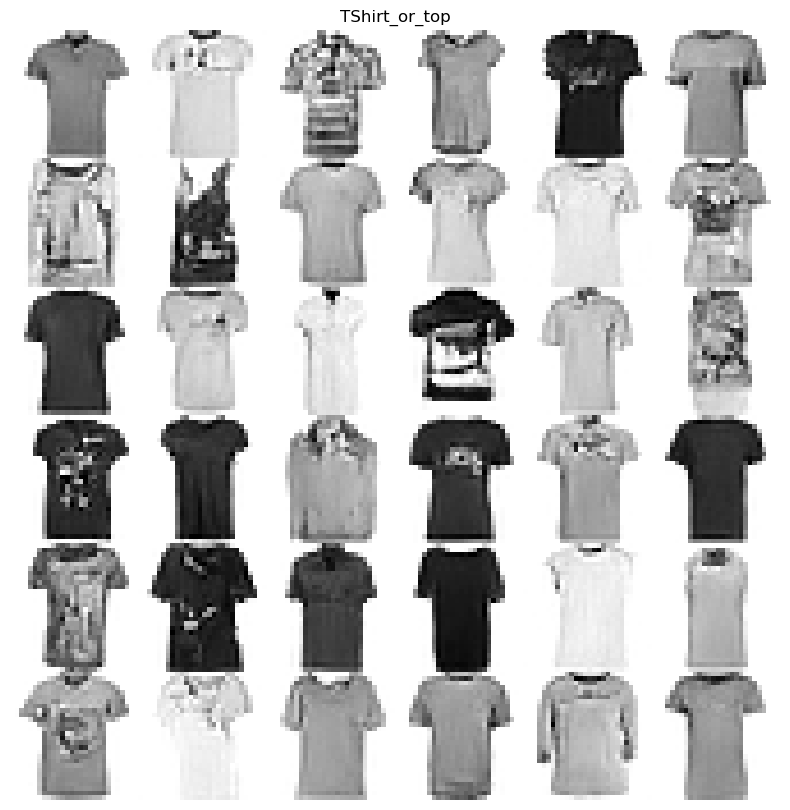

In [41]:
plot_montage(model, label=0);

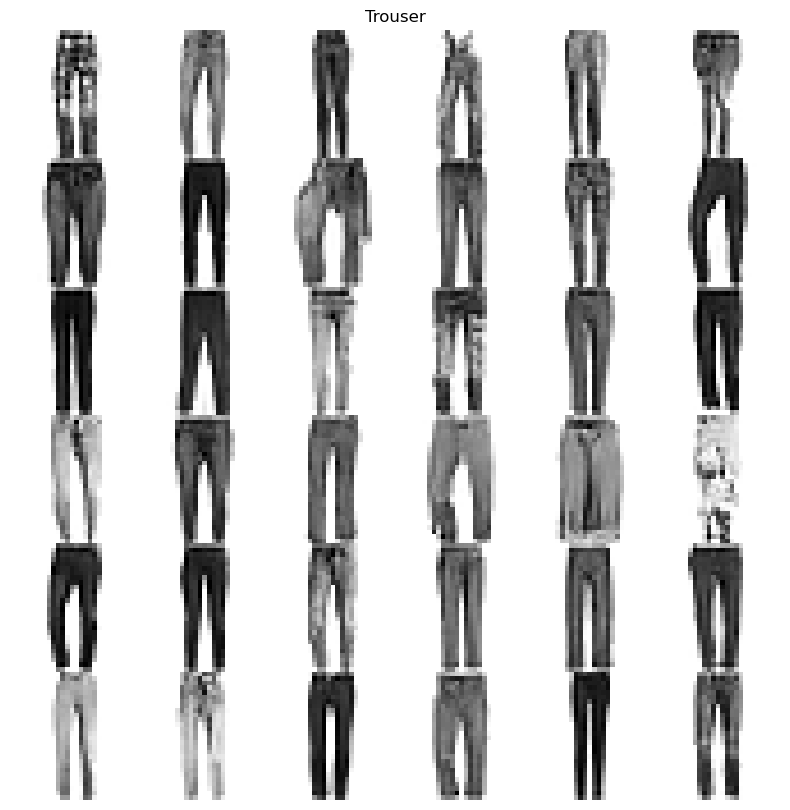

In [42]:
plot_montage(model, label=1);

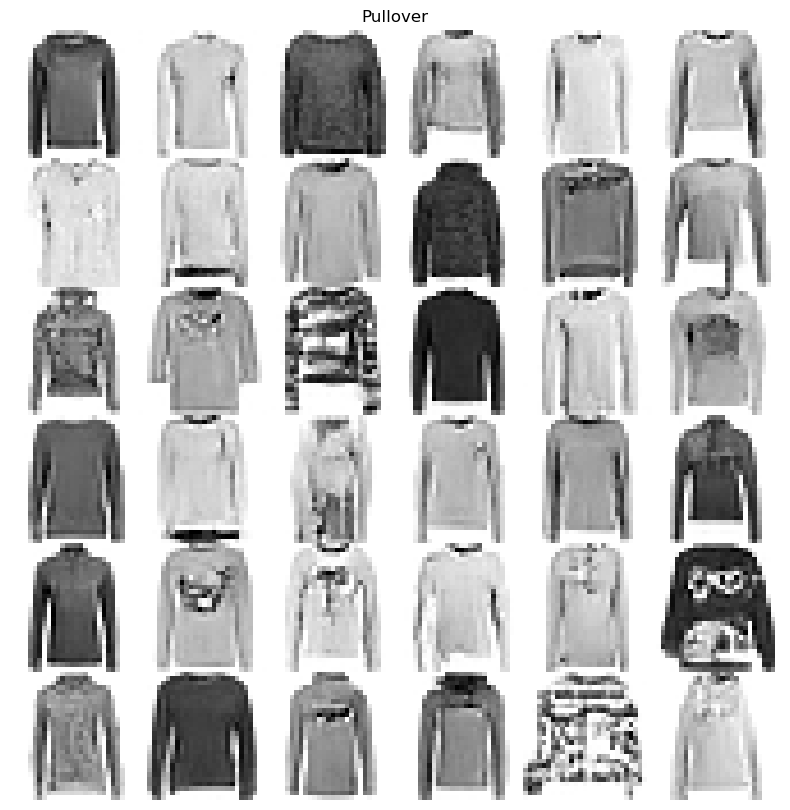

In [43]:
plot_montage(model, label=2);

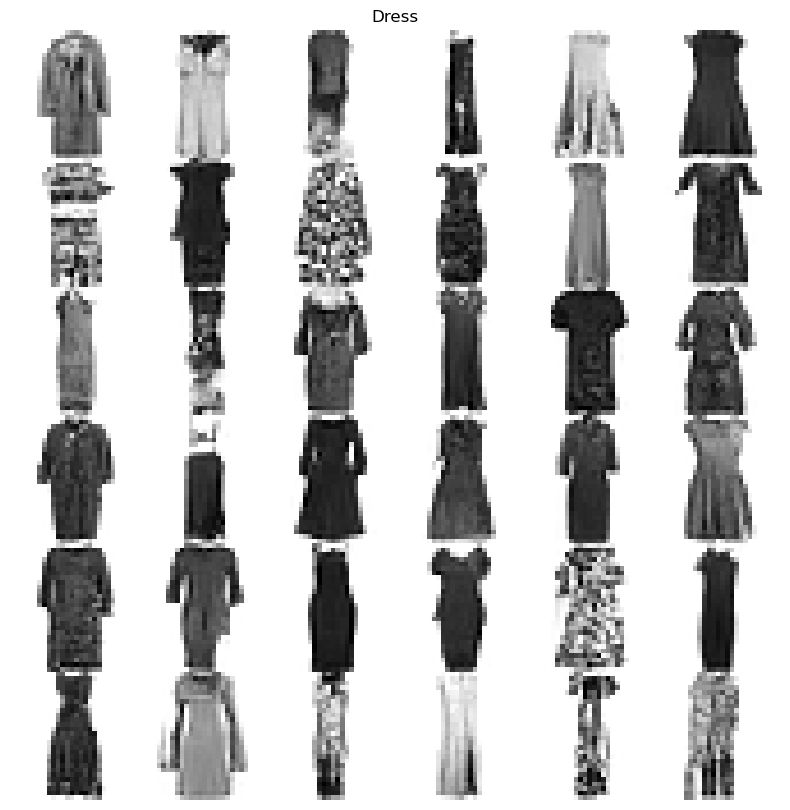

In [44]:
plot_montage(model, label=3);

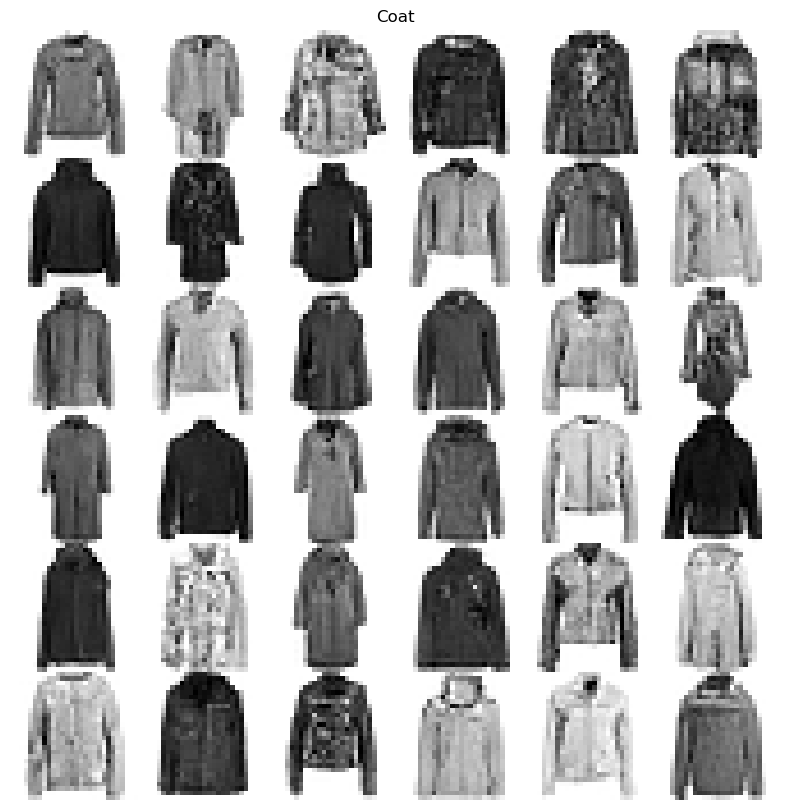

In [45]:
plot_montage(model, label=4);

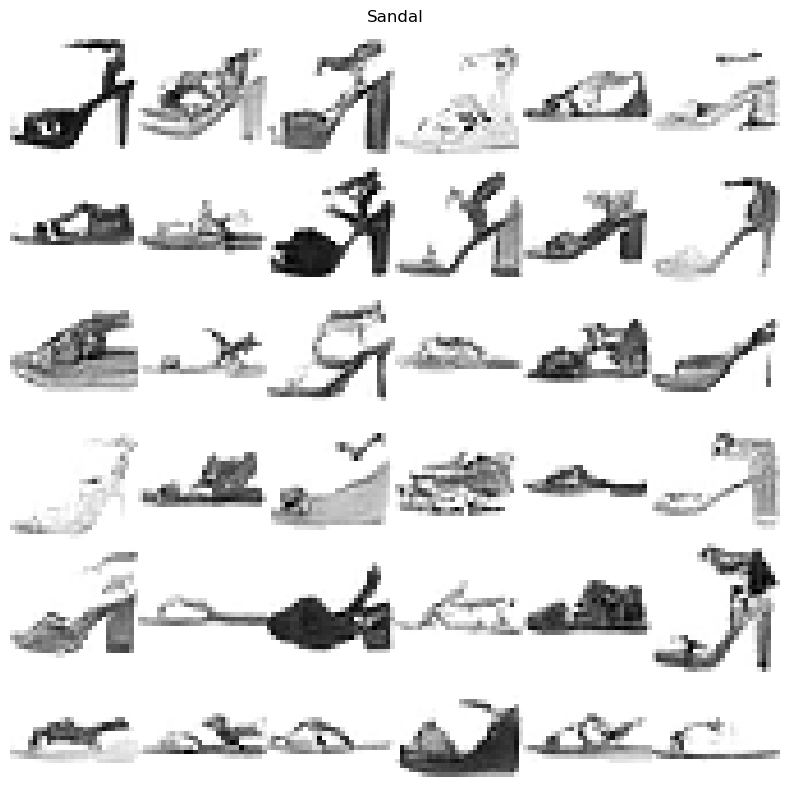

In [46]:
plot_montage(model, label=5);

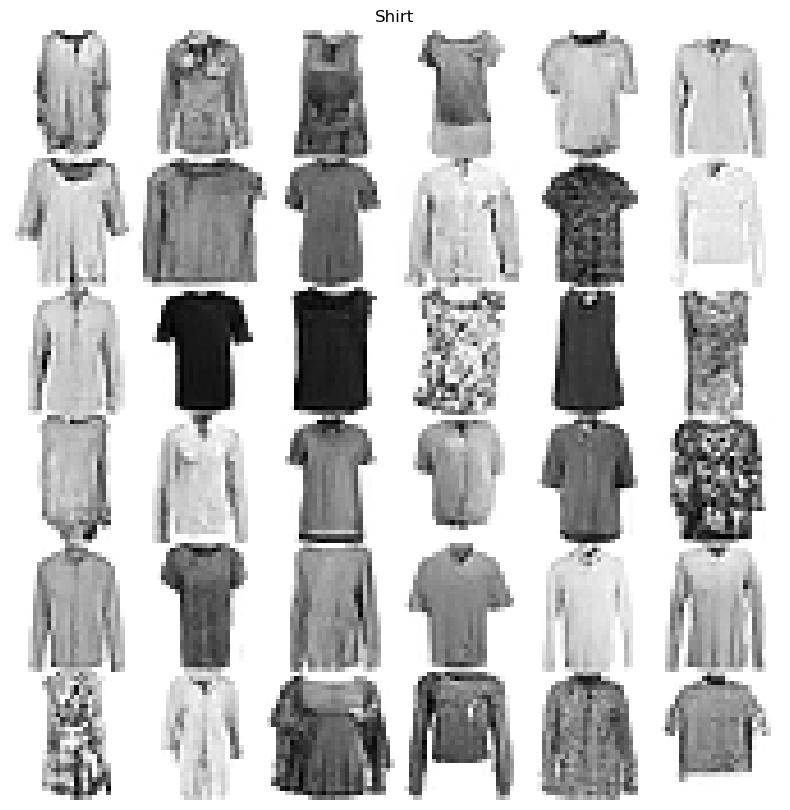

In [47]:
plot_montage(model, label=6);

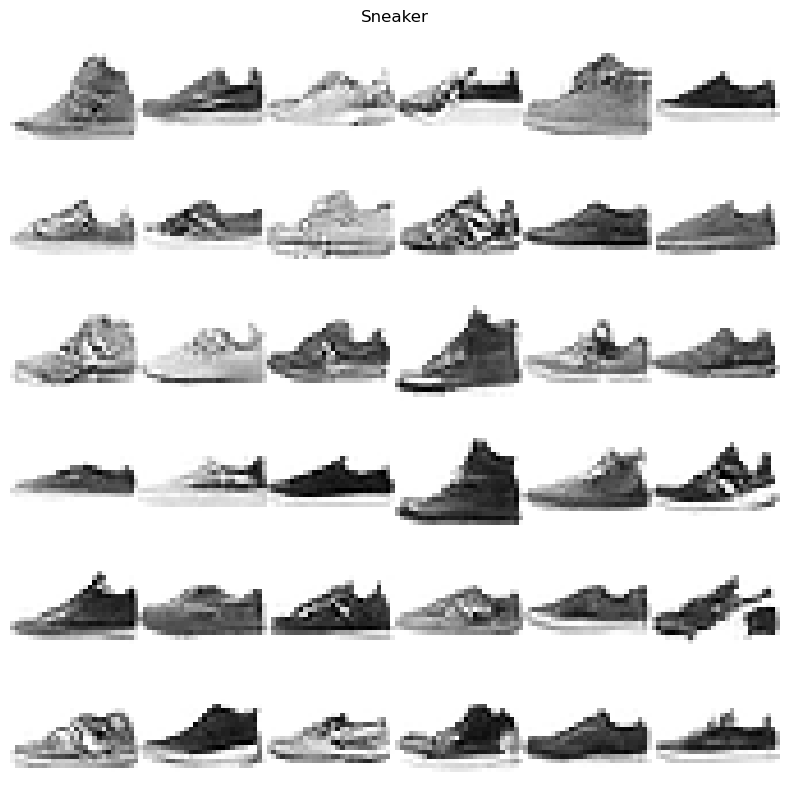

In [48]:
plot_montage(model, label=7);

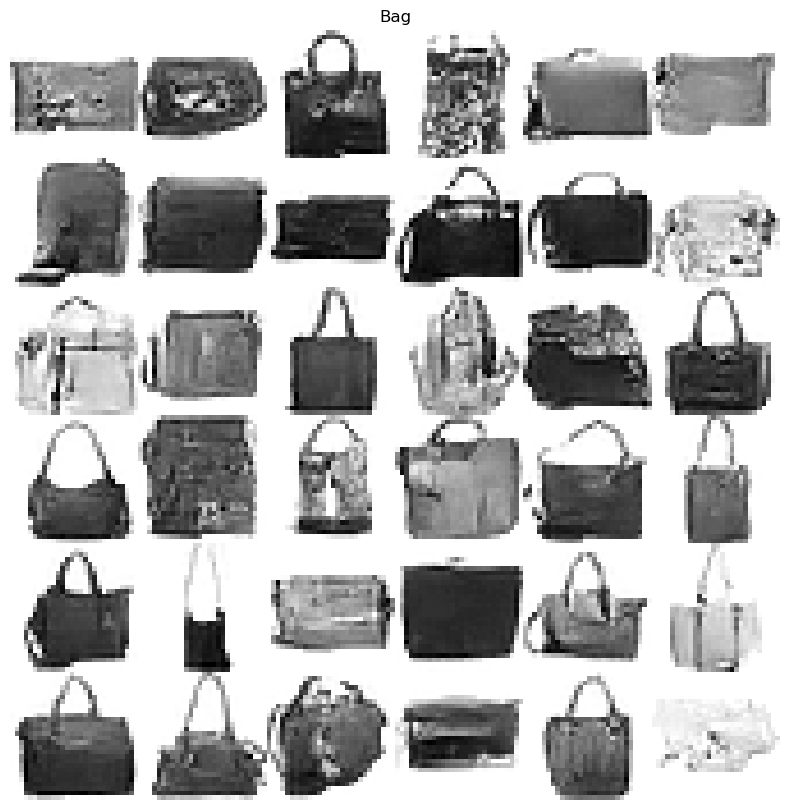

In [49]:
plot_montage(model, label=8);

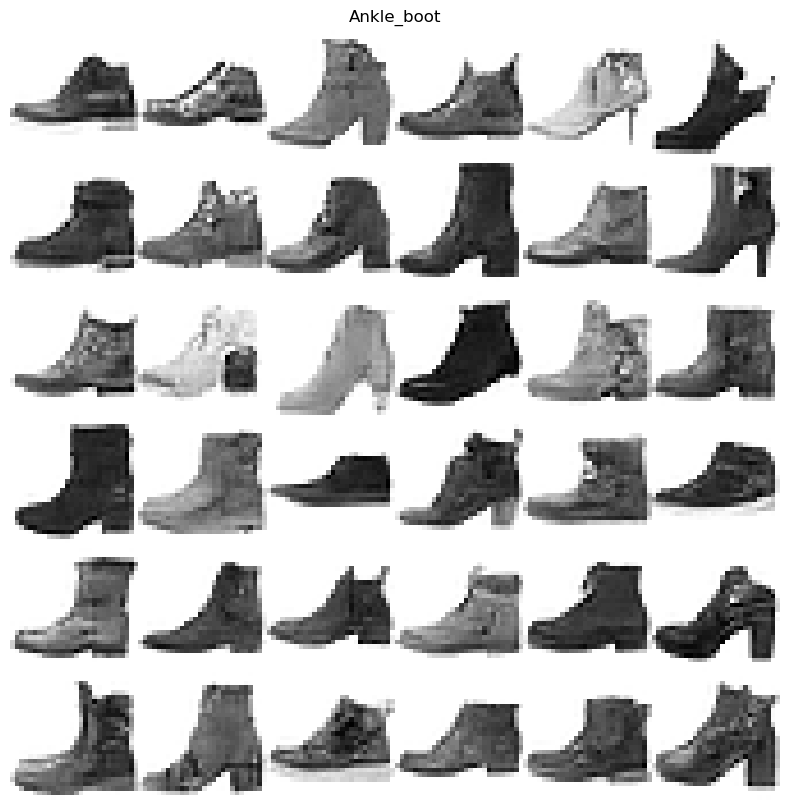

In [50]:
plot_montage(model, label=9);